In [600]:
import numpy as np

import pandas as pd

#from datetime import datetime

In [601]:
#Read the csv file
df = pd.read_csv('Cell_Level_KPI_5 layer site_ML-One sector.csv')
#df.head()

In [602]:
df.drop('Radio Site_Sector_Date_Hour',axis=1,inplace=True)
df.drop('Hour',axis=1,inplace=True)
df.drop('Date',axis=1,inplace=True)

In [603]:
#df.info()

In [604]:
df['Date_Time']= pd.to_datetime(df['Date_Time'])

In [605]:
#df.info()

In [606]:
df.Capacity_On_Off[df.Capacity_On_Off == 'On'] = 1
df.Capacity_On_Off[df.Capacity_On_Off == 'Off'] = 0

<ipython-input-606-b8846d583b5f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Capacity_On_Off[df.Capacity_On_Off == 'On'] = 1
<ipython-input-606-b8846d583b5f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Capacity_On_Off[df.Capacity_On_Off == 'Off'] = 0


In [607]:
df = df.rename({
          'Capacity_On_Off':'On'
        }, axis='columns')

In [608]:
df ['On'] =df['On'].astype('int')

In [609]:
#df.head()

In [610]:
#df.tail()

In [611]:
df1=df.reset_index()['On']

In [612]:
df1.tail()

911    1
912    1
913    0
914    1
915    0
Name: On, dtype: int32

In [613]:
#df1 = np.array(df1)

In [614]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler

import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [615]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)


In [616]:
training_size

595

In [617]:
test_size=len(df1)-training_size
test_size

321

In [618]:
train_data, test_data =df1[0:training_size,:],df1[training_size:len(df1),:1]

In [619]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [620]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 24
X_train, y_train = create_dataset(train_data, time_step)

In [621]:
X_test, ytest = create_dataset(test_data, time_step)

In [622]:
print(X_train.shape), print(y_train.shape)

(570, 24)
(570,)


(None, None)

In [623]:
print(X_test.shape), print(ytest.shape)

(296, 24)
(296,)


(None, None)

In [624]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [625]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [626]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [627]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 24, 50)            10400     
_________________________________________________________________
lstm_16 (LSTM)               (None, 24, 50)            20200     
_________________________________________________________________
lstm_17 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [628]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
9/9 [==============================] - 6s 150ms/step - loss: 0.3216 - val_loss: 0.2712
Epoch 2/100
9/9 [==============================] - 0s 43ms/step - loss: 0.2612 - val_loss: 0.2590
Epoch 3/100
9/9 [==============================] - 0s 40ms/step - loss: 0.2535 - val_loss: 0.2490
Epoch 4/100
9/9 [==============================] - 0s 42ms/step - loss: 0.2532 - val_loss: 0.2479
Epoch 5/100
9/9 [==============================] - 0s 44ms/step - loss: 0.2538 - val_loss: 0.2475
Epoch 6/100
9/9 [==============================] - 0s 55ms/step - loss: 0.2500 - val_loss: 0.2471
Epoch 7/100
9/9 [==============================] - 0s 42ms/step - loss: 0.2517 - val_loss: 0.2467
Epoch 8/100
9/9 [==============================] - 0s 41ms/step - loss: 0.2525 - val_loss: 0.2467
Epoch 9/100
9/9 [==============================] - 0s 42ms/step - loss: 0.2533 - val_loss: 0.2466
Epoch 10/100
9/9 [==============================] - 0s 41ms/step - loss: 0.2535 - val_loss: 0.2492
Epoch 11/100
9/9 [

Epoch 84/100
9/9 [==============================] - 0s 35ms/step - loss: 0.0623 - val_loss: 0.1047
Epoch 85/100
9/9 [==============================] - 0s 44ms/step - loss: 0.0623 - val_loss: 0.0965
Epoch 86/100
9/9 [==============================] - 0s 36ms/step - loss: 0.0580 - val_loss: 0.0986
Epoch 87/100
9/9 [==============================] - 0s 36ms/step - loss: 0.0571 - val_loss: 0.0990
Epoch 88/100
9/9 [==============================] - 0s 36ms/step - loss: 0.0572 - val_loss: 0.0969
Epoch 89/100
9/9 [==============================] - 0s 42ms/step - loss: 0.0551 - val_loss: 0.1037
Epoch 90/100
9/9 [==============================] - 0s 38ms/step - loss: 0.0595 - val_loss: 0.1004
Epoch 91/100
9/9 [==============================] - 0s 37ms/step - loss: 0.0553 - val_loss: 0.0910
Epoch 92/100
9/9 [==============================] - 0s 36ms/step - loss: 0.0556 - val_loss: 0.0944
Epoch 93/100
9/9 [==============================] - 0s 34ms/step - loss: 0.0530 - val_loss: 0.0933
Epoch 94/1

In [629]:
import tensorflow as tf

In [630]:
tf.__version__

'2.6.0'

# Now we will predict for Train and Test data and find the accuracy of both predictions.

In [631]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [632]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [633]:
train_predict = np.round(train_predict)

In [634]:
#train_predict = pd.DataFrame(train_predict, columns=['train_predict']).to_csv('train_predict.csv')

In [635]:
test_predict = np.round(test_predict)

In [636]:
#test_predict = pd.DataFrame(test_predict, columns=['test_predict']).to_csv('test_predict.csv')

In [637]:
#train_predict

In [638]:
#zbc = np.isnan(train_predict)

In [639]:
#countNAN = np.where (zbc== 'True')

In [640]:
#countNAN

In [641]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.2581988897471611

In [642]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

0.3389171947022825

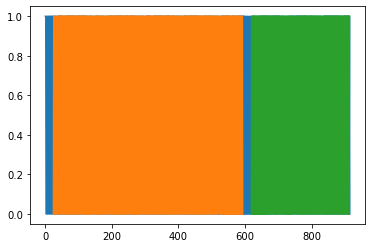

In [643]:
### Plotting train_predict and test_predict
# shift train predictions for plotting
look_back=time_step   # this value should be same as time_step considerd in code above.
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [644]:

len(test_data)

321

# Below code is for predicting values for a future date (beyond test data set). Of course we wont be able to validate how accurate that prediction is, since we dont have any future data.

In [645]:
len(test_data)

321

In [646]:
# If the 'last hour of last date' in our entire data set is say Hour- H24 of Day- D7. 
# If we have to predict H1 of D8 looking back H24 - 24 (24 hrs before), then this is calaculated as below.

new = (len(test_data)-time_step)

In [647]:
# 
x_input=test_data[new:].reshape(1,-1) 

## first agument in test_data should be the output of earlier executed command print(ytest.shape) and add 1 to it
# .==remove above comment??

x_input.shape

(1, 24)

In [648]:
# Below will give list of values for the period 'time_step'
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [649]:
# demonstrate prediction for next x no of time steps in the future
from numpy import array

lst_output=[]
n_steps=time_step # step size should be same as was chosen in the code earlier/above 
i=0
while(i<48):   # value of i to be given here as the no of time steps in the future that we want to predict for
                # This is basically how many hours after last hour of our data set do we want to predict considering look
                # back period of time_step (time_step is defined earlier)
    
    if(len(temp_input)>time_step): # value givne here should be same a time_steps used in earlier code above.
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.9794723]
25
1 day input [0.         0.         0.         1.         1.         0.
 1.         0.         1.         1.         0.         1.
 0.         1.         1.         0.         1.         0.
 1.         1.         0.         1.         0.         0.97947228]
1 day output [[0.8795685]]
2 day input [0.         0.         1.         1.         0.         1.
 0.         1.         1.         0.         1.         0.
 1.         1.         0.         1.         0.         1.
 1.         0.         1.         0.         0.97947228 0.87956852]
2 day output [[-0.03838972]]
3 day input [ 0.          1.          1.          0.          1.          0.
  1.          1.          0.          1.          0.          1.
  1.          0.          1.          0.          1.          1.
  0.          1.          0.          0.97947228  0.87956852 -0.03838972]
3 day output [[0.8221379]]
4 day input [ 1.          1.          0.          1.          0.          1.
  1.          0.          1.  

29 day output [[0.6022015]]
30 day input [ 0.69542021 -0.05638836  0.84526896  0.36102265  1.00658751  0.08228353
  0.37997586  0.40896219  0.97335958  0.63092196 -0.1252629   0.71537799
  0.41519421  1.02160299 -0.03032042  0.59280729  0.07844158  0.934138
  0.8186667  -0.08047978  0.74654752  0.11129579  1.01711321  0.60220152]
30 day output [[-0.04879864]]
31 day input [-0.05638836  0.84526896  0.36102265  1.00658751  0.08228353  0.37997586
  0.40896219  0.97335958  0.63092196 -0.1252629   0.71537799  0.41519421
  1.02160299 -0.03032042  0.59280729  0.07844158  0.934138    0.8186667
 -0.08047978  0.74654752  0.11129579  1.01711321  0.60220152 -0.04879864]
31 day output [[0.8134862]]
32 day input [ 0.84526896  0.36102265  1.00658751  0.08228353  0.37997586  0.40896219
  0.97335958  0.63092196 -0.1252629   0.71537799  0.41519421  1.02160299
 -0.03032042  0.59280729  0.07844158  0.934138    0.8186667  -0.08047978
  0.74654752  0.11129579  1.01711321  0.60220152 -0.04879864  0.81348622]

Convert predicted value to categorical output, round it.

In [665]:
lst_output = np.round(lst_output)

In [650]:
# below second argument should be n_steps from above and add 1 to it
day_new=np.arange(1,time_step+1)
# below first agument should be n_steps from above and add 1 to it.
# below second agument should be-> n_steps+ number future time steps that we wnat to predict in the future. 
# This value of future time steps is given in above code while(i<100)
day_pred=np.arange(time_step+1,time_step+i+1)

# above i+1 is added, since in the earlier code, i value is true only till it is '<48'. 

In [675]:
#day_pred

In [652]:
import matplotlib.pyplot as plt

In [657]:
var1 = len(df1)-time_step

In [674]:
#var1

In [676]:
#len(df1[var1:])

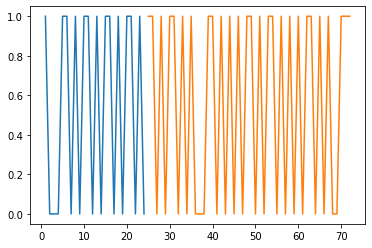

In [668]:
# Value belos should be len(df1) minus value of future time step as considered above
plt.plot(day_new,scaler.inverse_transform(df1[var1:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

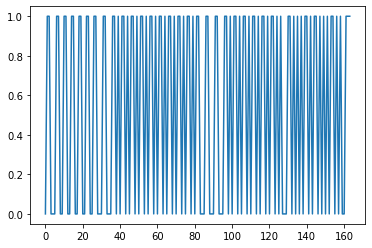

In [673]:
# This shows complete plot of train, test and future date prediction plot- all in one plot.
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[800:]) # dont know the meaning of the value in this code but surely has no relation with above code at all.